In [182]:
from src.data.processing import load_datasets, merge_dataframes, save_merged_df, load_merged_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.config.settings import configure_logging
configure_logging()
plt.style.use('fivethirtyeight')

1. Data preparation

In [108]:
# Use this the first time to save the merged data as a .csv file
#customers, transactions = load_datasets()
#df = merge_dataframes(customers, transactions)
#save_merged_df(merged_df=df)

# If you already have merged_sme_data.csv in data/raw, you can load it:
df = load_merged_df()

2025-12-09 11:21:48,639 [INFO] src.data.processing._safe_read_csv: Loading data/raw/merged_sme_data.csv
/app/src/data/processing.py:13: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


In [109]:
# Convert timestamps, sort by time and customer, so it is time-ordered per customer
df['BookingDatetime'] = pd.to_datetime(df['BookingDatetime'])
df = df.sort_values(['cust_id', 'BookingDatetime'])

df['amount_signed'] = df.apply(
    lambda row: row['Amount_EUR'] if row['D_C'] == 'D' else -row['Amount_EUR'],
    axis=1
)

df = df.drop_duplicates(
    subset=['cust_id', 'amount_signed', 'BookingDatetime', 'D_C']
)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['BookingDatetime'].min()} to {df['BookingDatetime'].max()}")
print(f"Unique customers: {df['cust_id'].nunique()}")

df = df.set_index('BookingDatetime')
df.head()

Dataset shape: (1267435, 19)
Date range: 2023-01-01 00:00:00 to 2024-12-31 23:58:06
Unique customers: 958


,WeekDay,Channel,cust_id,D_C,Currency_trx,Amount_EUR,Customer_IBAN,Counterparty_IBAN,Amount_Orig,currency,MCC,country_of_merchant,customer_type,parent_company_flag,CUST_GRP_ID,BRTH_DT,language,amount_signed
BookingDatetime,,,,,,,,,,,,,,,,,,
2023-01-01 03:56:39,7,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,C,EUR,0.010024,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,0.010024,EUR,NaN,NaN,SME,1,NaN,1995-1999,RUS,-0.010024
2023-01-08 01:43:51,7,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,D,EUR,1.002405,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,7ecc6d620a9ea4170231178c236206770eb7a4785d2a6c...,1.002405,EUR,NaN,NaN,SME,1,NaN,1995-1999,RUS,1.002405
2023-01-16 11:56:38,1,ATM,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,C,EUR,3007.214307,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,7ecc6d620a9ea4170231178c236206770eb7a4785d2a6c...,3007.214307,EUR,NaN,NaN,SME,1,NaN,1995-1999,RUS,-3007.214307
2023-01-16 13:36:58,1,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,D,EUR,240.577145,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,b4483dd6637ede4ad784b0265188dd2e5441589f261c7b...,240.577145,EUR,NaN,NaN,SME,1,NaN,1995-1999,RUS,240.577145
2023-01-16 13:40:50,1,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,D,EUR,2906.973830,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,375ccaa15fb9358c6e5c90bbe0f1020161e6030ac859d9...,2906.973830,EUR,NaN,NaN,SME,1,NaN,1995-1999,RUS,2906.973830


In [91]:
daily = df.groupby(['cust_id'])['amount_signed'].resample('D').sum()
daily = daily.reset_index(name='net_flow')

In [ ]:
def create_features(df, target=None):
    df['hour'] = df['BookingDatetime'].dt.hour
    df['dayofweek'] = df['BookingDatetime'].dt.dayofweek
    df['quarter'] = df['BookingDatetime'].dt.quarter
    df['month'] = df['BookingDatetime'].dt.month
    df['year'] = df['BookingDatetime'].dt.year
    df['dayofyear'] = df['BookingDatetime'].dt.dayofyear
    df['dayofmonth'] = df['BookingDatetime'].dt.day

    lags = [1,7,14,30]
    lag_cols = []
    for l in lags:
        col_name = f'lag_{l}'
        df[col_name] = df.groupby('cust_id')['net_flow'].shift(l)
        lag_cols.append(col_name)

    windows = [7,14,30]
    roll_cols = []
    for w in windows:
        mean_col = f'roll_mean_{w}'
        std_col = f'roll_std_{w}'
        df[mean_col] = df.groupby('cust_id')['net_flow'].shift(1).rolling(w).mean()
        df[std_col] = df.groupby('cust_id')['net_flow'].shift(1).rolling(w).std()
        roll_cols.extend([mean_col, std_col])

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth'] + lag_cols + roll_cols]

    if target:
        y = df[target]
        return X, y
    return X


In [170]:
cust_id = df.iloc[0]['cust_id']
ts = df.loc[df['cust_id'] == cust_id]
ts_daily = ts.groupby(['cust_id'])['amount_signed'].resample('D').sum()
ts_daily = ts_daily.reset_index(name='net_flow')
train_val, test = train_test_split(ts_daily, test_size=0.2)

train, val = train_test_split(train_val, test_size=0.25)

X_train, y_train = create_features(train, target='net_flow')
X_val, y_val = create_features(val, target='net_flow')
X_test, y_test = create_features(test, target='net_flow')


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {'max_depth': 6, 'eta': 0.5}
evals_list = [(dtrain, 'train'), (dval, 'validation')]
bst = xgb.train(params=params, dtrain=dtrain, evals=evals_list, early_stopping_rounds=50)

[0]	train-rmse:446.58409	validation-rmse:999.65157
[1]	train-rmse:340.27603	validation-rmse:1026.25446
[2]	train-rmse:253.00097	validation-rmse:1073.72091
[3]	train-rmse:204.40883	validation-rmse:1107.98292
[4]	train-rmse:168.36371	validation-rmse:1117.65124
[5]	train-rmse:149.87509	validation-rmse:1116.75162
[6]	train-rmse:130.26697	validation-rmse:1123.91667
[7]	train-rmse:111.46791	validation-rmse:1129.75121
[8]	train-rmse:100.62218	validation-rmse:1131.68573
[9]	train-rmse:94.73945	validation-rmse:1132.83047


In [206]:
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
        )

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


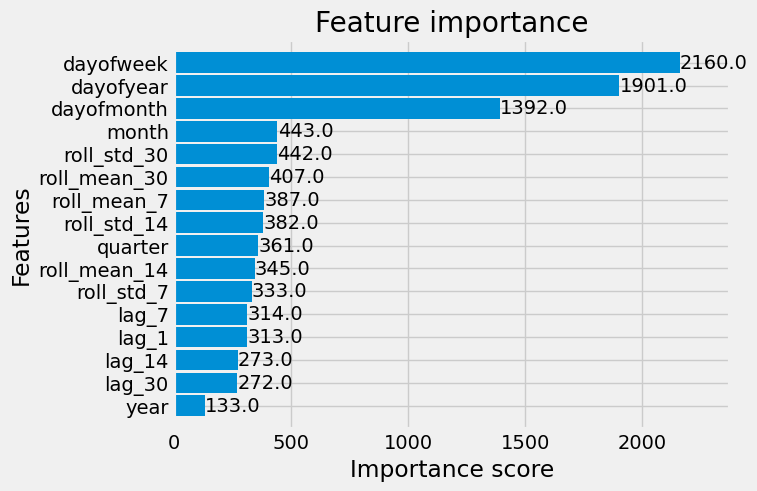

In [207]:
_ = plot_importance(reg, height=0.9)

In [208]:
test['prediction'] = reg.predict(X_test)

In [209]:
mean_absolute_error(test['net_flow'], test['prediction'])

928.8943287042931